# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
%matplotlib inline
from time import sleep, time

import matplotlib.pyplot as plt
import numpy as np
from IPython import display
from tqdm import tqdm as tqdm
from modules import *

X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [62]:
from sklearn.preprocessing import OneHotEncoder

categories = np.array(list(range(0, 10)))
y_train = (
    OneHotEncoder(categories=[categories])
    .fit_transform(y_train.reshape(-1, 1))
    .todense()
)
y_val = (
    OneHotEncoder(categories=[categories]).fit_transform(y_val.reshape(-1, 1)).todense()
)
y_test = (
    OneHotEncoder(categories=[categories])
    .fit_transform(y_test.reshape(-1, 1))
    .todense()
)
y_test = np.array(y_test)
y_val = np.array(y_val)
y_train = np.array(y_train)
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [132]:
np.array(y_test)

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Universal training loop

In [11]:
import time


def train_net(
    model: Module,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    optimizer_config,
    n_epochs=10,
    batch_size=128,
    viz=True,
    score_func=None,
):

    optimizer_state = {}
    epoch_val_losses = []
    epoch_train_losses = []
    epoch_times = []
    scores = []

    for i in tqdm(range(n_epochs)):
        losses = []
        epoch_start = time.time()
        model.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            model.zeroGradParameters()

            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            grads = criterion.backward(predictions, y_batch)
            model.backward(x_batch, grads)

            optimizer(
                model.getParameters(),
                model.getGradParameters(),
                optimizer_config,
                optimizer_state,
            )

            losses.append(loss)

        epoch_times.append(time.time() - epoch_start)
        epoch_train_losses.append(np.mean(losses))
        model.evaluate()
        y_val_pred = model.forward(X_val)
        epoch_val_loss = criterion.forward(y_val_pred, y_val)
        epoch_val_losses.append(epoch_val_loss)

        if score_func:
            scores.append(score_func(y_val, y_val_pred))

        if viz:
            display.clear_output(wait=True)
            plt.figure(figsize=(8, 6))

            plt.title("Training process")
            plt.xlabel("iteration")
            plt.ylabel("loss")
            plt.plot(epoch_train_losses, label="train")
            plt.plot(epoch_val_losses, label="val")
            plt.legend()
            plt.show()
            # print(f'time: {epoch_times[-1]}')

    return epoch_val_losses, epoch_train_losses, epoch_times, scores

In [12]:
def accuracy_score(y_true, y_pred_prob):
    return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred_prob, axis=1))

# Comparing activations

In [391]:
activations = [ReLU, LeakyReLU, ELU, SoftPlus]
optimizer = adam_optimizer

optimizer_config = {
    "learning_rate": 1e-3,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
}

results = {}


for activation in activations:

    model = Sequential()
    model.add(Linear(784, 100))
    model.add(activation())
    model.add(Linear(100, 40))
    model.add(activation())
    model.add(Linear(40, 10))
    model.add(LogSoftMax())

    epoch_val_losses, epoch_train_losses, epoch_times, scores = train_net(
        model,
        X_train,
        y_train,
        X_val,
        y_val,
        optimizer,
        optimizer_config,
        n_epochs=30,
        batch_size=250,
        viz=False,
        score_func=accuracy_score,
    )

    results.setdefault(
        activation.__name__, [epoch_val_losses, epoch_train_losses, epoch_times, scores]
    )

100%|██████████| 30/30 [01:41<00:00,  3.37s/it]


ReLU train time:  79.7, best_score %: 97.68
LeakyReLU train time:  79.6, best_score %: 97.52
ELU train time:  89.4, best_score %: 97.64
SoftPlus train time:  96.3, best_score %: 97.72


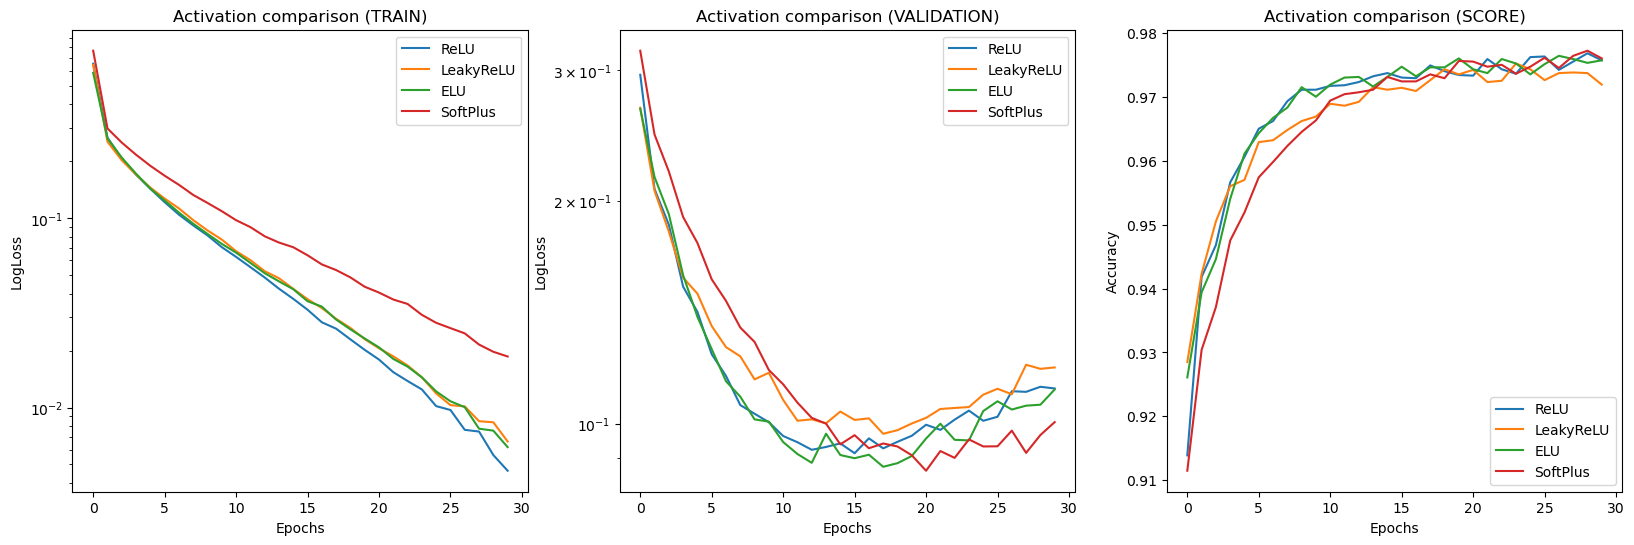

In [392]:
fig, (train, val, score) = plt.subplots(1, 3, figsize=(20, 6))

train.set_xlabel("Epochs")
train.set_ylabel("LogLoss")
train.set_title("Activation comparison (TRAIN)")

val.set_xlabel("Epochs")
val.set_ylabel("LogLoss")
val.set_title("Activation comparison (VALIDATION)")

score.set_xlabel("Epochs")
score.set_ylabel("Accuracy")
score.set_title("Activation comparison (SCORE)")

for activation, (
    epoch_val_losses,
    epoch_train_losses,
    epoch_times,
    scores,
) in results.items():
    # print(activation)
    print(
        f"{activation} train time: {round(sum(epoch_times),1):5}, best_score %: {round(max(scores)*100,2)}"
    )
    val.plot(epoch_val_losses, label=f"{activation}")
    train.plot(epoch_train_losses, label=f"{activation}")
    score.plot(scores, label=f"{activation}")
val.legend()
train.legend()
score.legend()
train.set_yscale("log")
val.set_yscale("log")

**Leaky ReLU and ELU seem to be the most powerful activations**

**Even though SoftPlus is more biologically accurate, it needs more time to train**

**So we are going to use only LeakyReLu and ELU**

# Comparing Batchnormalizatiion effect

In [393]:
activations = [LeakyReLU, ELU]
batchnorms = [False, True]
bathcnorm_alpha = 0.95
optimizer = adam_optimizer

optimizer_config = {
    "learning_rate": 1e-3,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
}

results = {}

for activation in activations:
    for batchnorm in batchnorms:

        model = Sequential()
        model.add(Linear(784, 100))

        if batchnorm:
            model.add(BatchNormalization(bathcnorm_alpha))
            model.add(ChannelwiseScaling(100))

        model.add(activation())
        model.add(Linear(100, 40))

        if batchnorm:
            model.add(BatchNormalization(bathcnorm_alpha))
            model.add(ChannelwiseScaling(40))

        model.add(activation())
        model.add(Linear(40, 10))
        model.add(LogSoftMax())

        epoch_val_losses, epoch_train_losses, epoch_times, scores = train_net(
            model,
            X_train,
            y_train,
            X_val,
            y_val,
            optimizer,
            optimizer_config,
            n_epochs=30,
            batch_size=250,
            viz=False,
            score_func=accuracy_score,
        )

        results.setdefault(
            f"{activation.__name__}" + ("_bnorm" if batchnorm else ""),
            [epoch_val_losses, epoch_train_losses, epoch_times, scores],
        )

100%|██████████| 30/30 [01:44<00:00,  3.48s/it]


LeakyReLU train time:  85.0, best_score %: 97.64
LeakyReLU_bnorm train time:  89.7, best_score %: 97.96
ELU train time:  99.8, best_score %: 97.7
ELU_bnorm train time: 100.1, best_score %: 97.22


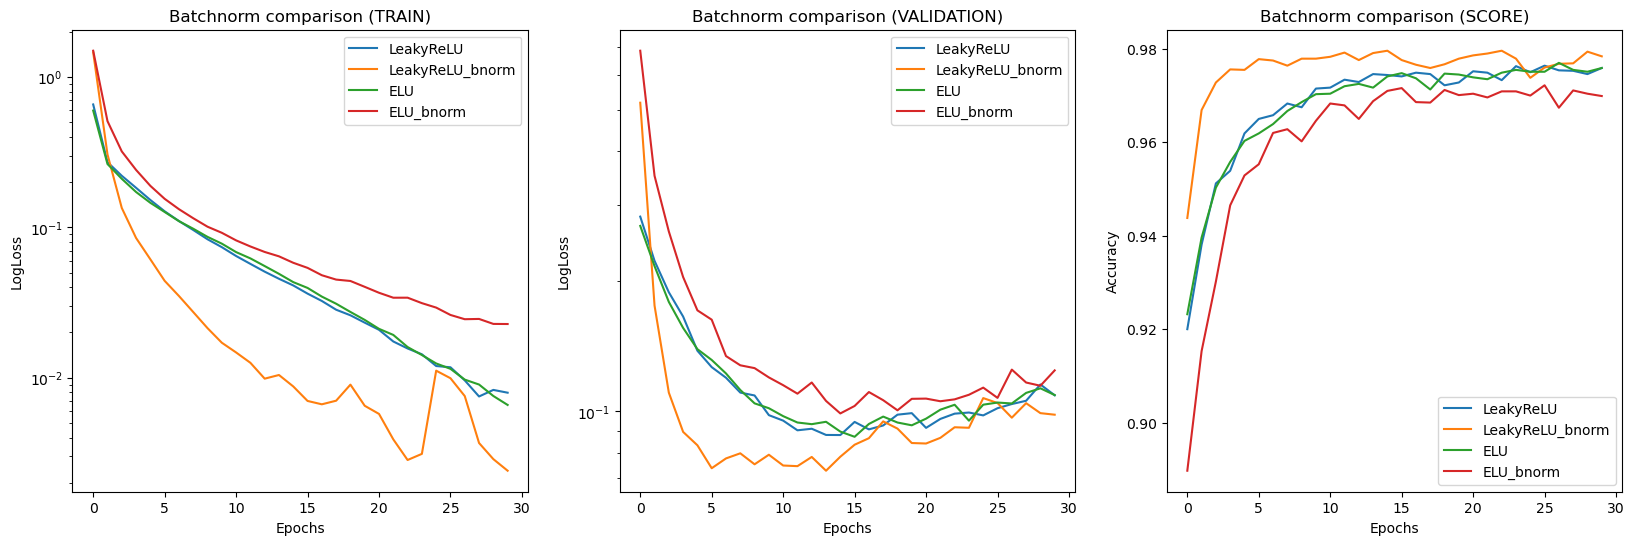

In [394]:
fig, (train, val, score) = plt.subplots(1, 3, figsize=(20, 6))

train.set_xlabel("Epochs")
train.set_ylabel("LogLoss")
train.set_title("Batchnorm comparison (TRAIN)")

val.set_xlabel("Epochs")
val.set_ylabel("LogLoss")
val.set_title("Batchnorm comparison (VALIDATION)")

score.set_xlabel("Epochs")
score.set_ylabel("Accuracy")
score.set_title("Batchnorm comparison (SCORE)")

for activation, (
    epoch_val_losses,
    epoch_train_losses,
    epoch_times,
    scores,
) in results.items():
    # print(activation)
    print(
        f"{activation} train time: {round(sum(epoch_times),1):5}, best_score %: {round(max(scores)*100,2)}"
    )
    val.plot(epoch_val_losses, label=f"{activation}")
    train.plot(epoch_train_losses, label=f"{activation}")
    score.plot(scores, label=f"{activation}")
val.legend()
train.legend()
score.legend()
train.set_yscale("log")
val.set_yscale("log")

**Batchnorm has really boosted the convergence and quality of the LeakyReLU model, but made ELU convergence worse**

**Further we are going to use only LeakyReLU with batchnorm**

# Comparing optimizers

In [395]:
from functools import partial

activations = [LeakyReLU]
batchnorms = [True]
bathcnorm_alpha = 0.95


base_ADAM_config = {
    "learning_rate": 1e-3,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
}

base_SGDMomentum_config = {"learning_rate": 1e-1, "momentum": 0.9}

optimizers = [adam_optimizer, sgd_momentum]
optimizers_configs = [base_ADAM_config, base_SGDMomentum_config]
optimizers_learning_rates = [[1e-2, 1e-3, 1e-4], [1, 1e-1, 1e-2]]


results = {}
for activation in activations:
    for batchnorm in batchnorms:
        for optimizer, config, learning_rates in zip(
            optimizers, optimizers_configs, optimizers_learning_rates
        ):
            for lr in learning_rates:
                model = Sequential()
                model.add(Linear(784, 100))

                if batchnorm:
                    model.add(BatchNormalization(bathcnorm_alpha))
                    model.add(ChannelwiseScaling(100))

                model.add(activation())
                model.add(Linear(100, 40))

                if batchnorm:
                    model.add(BatchNormalization(bathcnorm_alpha))
                    model.add(ChannelwiseScaling(40))

                model.add(activation())
                model.add(Linear(40, 10))
                model.add(LogSoftMax())

                config["learning_rate"] = lr
                epoch_val_losses, epoch_train_losses, epoch_times, scores = train_net(
                    model,
                    X_train,
                    y_train,
                    X_val,
                    y_val,
                    optimizer,
                    config,
                    n_epochs=40,
                    batch_size=250,
                    viz=False,
                    score_func=accuracy_score,
                )

                results.setdefault(
                    f"{activation.__name__}"
                    + ("_bnorm" if batchnorm else "")
                    + f" {optimizer.__name__}_lr_{lr}",
                    [epoch_val_losses, epoch_train_losses, epoch_times, scores],
                )

100%|██████████| 40/40 [01:53<00:00,  2.84s/it]


LeakyReLU_bnorm adam_optimizer_lr_0.01 train time: 130.9, best_score %: 97.95
LeakyReLU_bnorm adam_optimizer_lr_0.001 train time: 126.7, best_score %: 98.19
LeakyReLU_bnorm adam_optimizer_lr_0.0001 train time: 121.5, best_score %: 97.83
LeakyReLU_bnorm sgd_momentum_lr_1 train time: 109.1, best_score %: 97.9
LeakyReLU_bnorm sgd_momentum_lr_0.1 train time: 110.0, best_score %: 98.04
LeakyReLU_bnorm sgd_momentum_lr_0.01 train time: 109.1, best_score %: 97.82


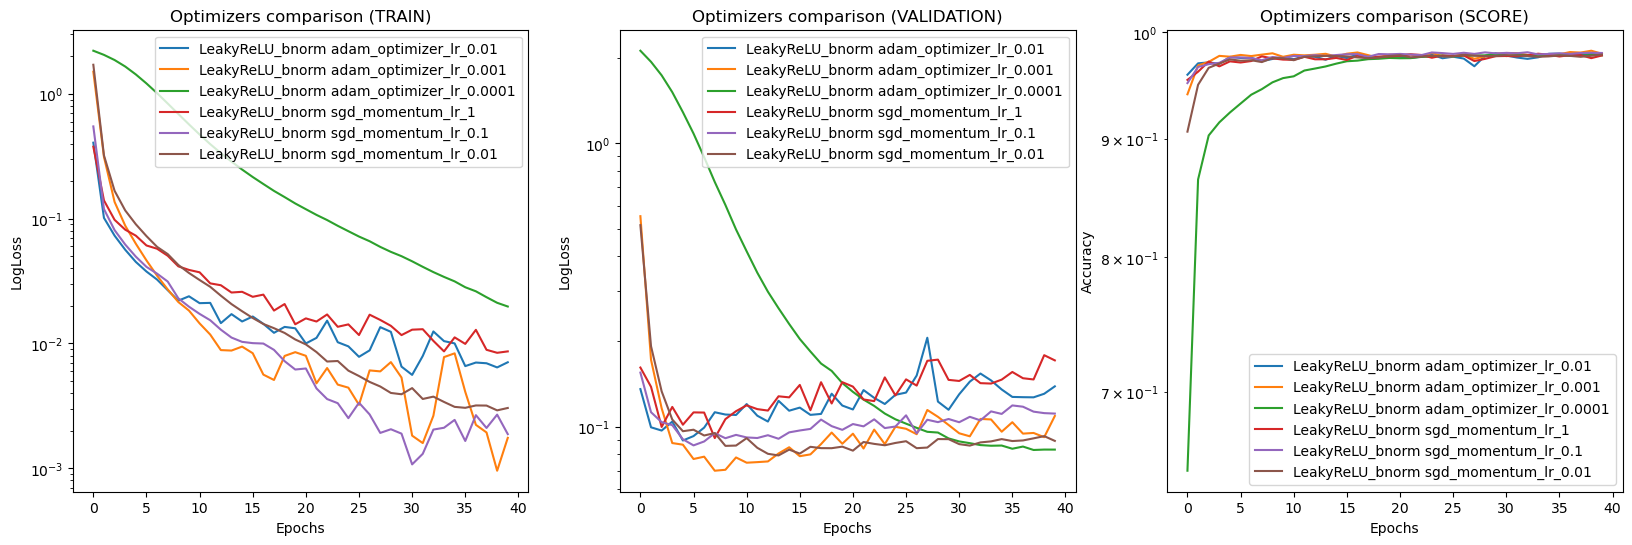

In [396]:
fig, (train, val, score) = plt.subplots(1, 3, figsize=(20, 6))

train.set_xlabel("Epochs")
train.set_ylabel("LogLoss")
train.set_title("Optimizers comparison (TRAIN)")

val.set_xlabel("Epochs")
val.set_ylabel("LogLoss")
val.set_title("Optimizers comparison (VALIDATION)")

score.set_xlabel("Epochs")
score.set_ylabel("Accuracy")
score.set_title("Optimizers comparison (SCORE)")

for activation, (
    epoch_val_losses,
    epoch_train_losses,
    epoch_times,
    scores,
) in results.items():
    # print(activation)
    print(
        f"{activation} train time: {round(sum(epoch_times),1):5}, best_score %: {round(max(scores)*100,2)}"
    )
    val.plot(epoch_val_losses, label=f"{activation}")
    train.plot(epoch_train_losses, label=f"{activation}")
    score.plot(scores, label=f"{activation}")
val.legend()
train.legend()
score.legend()
train.set_yscale("log")
val.set_yscale("log")
score.set_yscale("log")

# Best model training
As we learned before, the combiation of `LeakyReLU + BatchNorm + ADAM` is pretty good for this task, so lets make the network a little larger(by increasing the number of neurons in hidden layers)

Also, we should mention, that there is no need in using `Dropout` if `batchnorm` is already applied, so we won't use `Dropout`

In [76]:
cool_model = Sequential()

cool_model.add(Linear(784, 200))
cool_model.add(BatchNormalization(bathcnorm_alpha))
cool_model.add(ChannelwiseScaling(200))
cool_model.add(LeakyReLU())


cool_model.add(Linear(200, 60))
cool_model.add(BatchNormalization(bathcnorm_alpha))
cool_model.add(ChannelwiseScaling(60))
cool_model.add(LeakyReLU())


cool_model.add(Linear(60, 10))
cool_model.add(LogSoftMax())

Finally, lets implement new train loop with `learing rate decay on plateau` and `early stopping`

Also, we'll reduce batch size to make model a bit more unstable and resistant to local minimums

In [83]:
import time


def reduce_lr_on_plateau_early_stopping_train_net(
    model: Module,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    optimizer_config,
    lr_decay=0.95,
    reduce_lr_tol=5,
    stop_tol=20,
    n_epochs=100,
    batch_size=128,
    verb=True,
    score_func=accuracy_score,
):

    optimizer_state = {}
    epoch_val_losses = []
    epoch_train_losses = []
    epoch_times = []
    scores = []

    current_tol = 0
    best_model = None

    for i in tqdm(range(n_epochs)):
        losses = []
        epoch_start = time.time()
        model.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            model.zeroGradParameters()

            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
            grads = criterion.backward(predictions, y_batch)
            model.backward(x_batch, grads)

            optimizer(
                model.getParameters(),
                model.getGradParameters(),
                optimizer_config,
                optimizer_state,
            )

            losses.append(loss)

        epoch_times.append(time.time() - epoch_start)
        epoch_train_losses.append(np.mean(losses))
        model.evaluate()
        y_val_pred = model.forward(X_val)
        epoch_val_loss = criterion.forward(y_val_pred, y_val)
        epoch_val_losses.append(epoch_val_loss)
        epoch_val_score = score_func(y_val, y_val_pred)
        scores.append(epoch_val_score)

        if verb:
            display.clear_output(wait=True)

            lr = optimizer_config["learning_rate"]
            print(
                f"Train loss: {epoch_val_loss} Score: {epoch_val_score} tol {current_tol}"
            )
            print(
                f"Time: {round(sum(epoch_times),1):5}, lr: {round(lr,7) : 6} best loss: {round(min(epoch_val_losses),5)} best val score %: {round(max(scores)*100,2)}"
            )

        if epoch_val_score < max(scores):
            print(current_tol)
            current_tol += 1

        else:
            best_model = deepcopy(model)
            current_tol = 0

        if current_tol > reduce_lr_tol:
            print("Reducing lr")
            optimizer_config["learning_rate"] = (
                optimizer_config["learning_rate"] * lr_decay
            )

        if current_tol > stop_tol:
            print("Early stopping!")
            break

    print("\nUsed model:\n")
    print(str(model))

    return epoch_val_losses, epoch_train_losses, epoch_times, scores, best_model

In [84]:
base_ADAM_config = {
    "learning_rate": 1e-3,
    "beta1": 0.9,
    "beta2": 0.999,
    "epsilon": 1e-8,
}

(
    epoch_val_losses,
    epoch_train_losses,
    epoch_times,
    scores,
    best_model,
) = reduce_lr_on_plateau_early_stopping_train_net(
    cool_model,
    X_train,
    y_train,
    X_val,
    y_val,
    adam_optimizer,
    base_ADAM_config,
    score_func=accuracy_score,
)

 59%|█████▉    | 59/100 [06:03<04:12,  6.16s/it]

Train loss: 0.10612323397544719 Score: 0.9828 tol 20
Time: 349.8, lr:  0.0002378 best loss: 0.07806 best val score %: 98.46
20
Reducing lr
Early stopping!

Used model:

Linear 784 -> 200
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 200 -> 60
BatchNormalization
ChannelwiseScaling
LeakyReLU
Linear 60 -> 10
LogSoftMax



In [88]:
%matplotlib inline

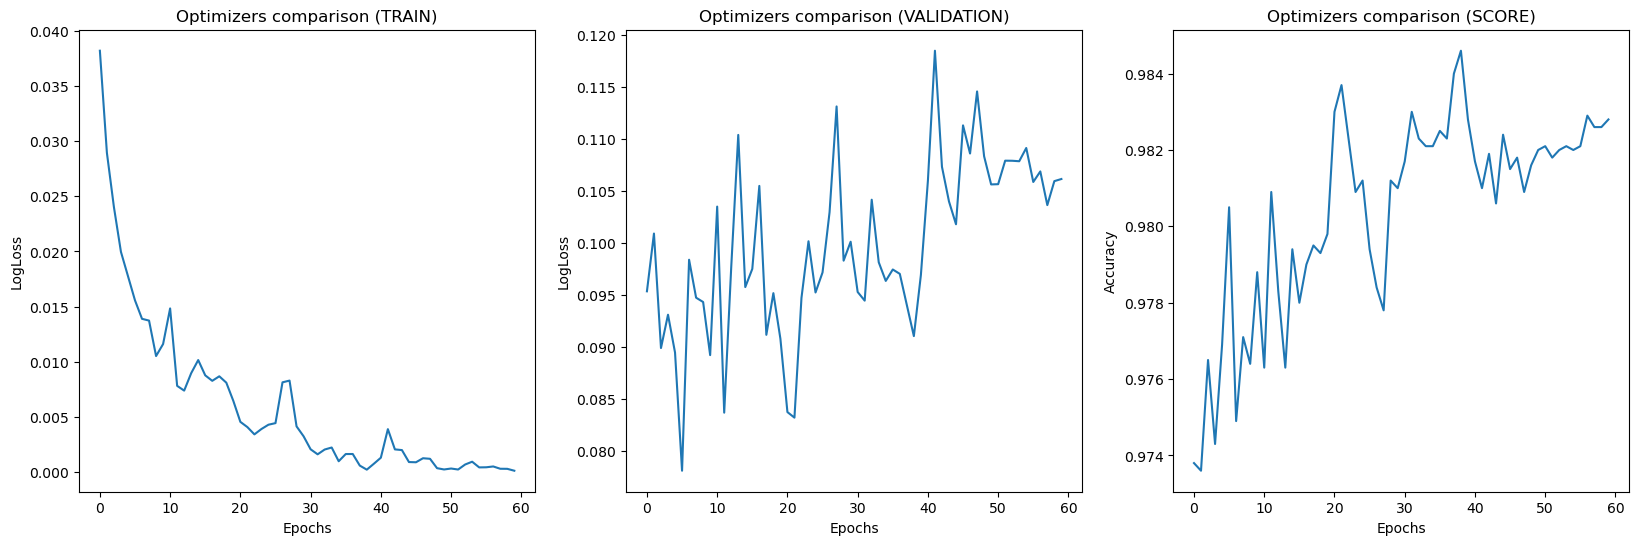

In [90]:
fig, (train, val, score) = plt.subplots(1, 3, figsize=(20, 6))
# train.set_yscale("log")
# val.set_yscale("log")
# score.set_yscale("log")

train.set_xlabel("Epochs")
train.set_ylabel("LogLoss")
train.set_title("Optimizers comparison (TRAIN)")

val.set_xlabel("Epochs")
val.set_ylabel("LogLoss")
val.set_title("Optimizers comparison (VALIDATION)")

score.set_xlabel("Epochs")
score.set_ylabel("Accuracy")
score.set_title("Optimizers comparison (SCORE)")

val.plot(epoch_val_losses)
train.plot(epoch_train_losses)
score.plot(scores)

# Evaluation & test score

In [86]:
best_model.evaluate()
test_predictions = best_model.forward(X_test)
score = accuracy_score(test_predictions, y_test)
print(f"Accuracy on test: {round(score*100,2)} %")

Accuracy on test: 98.39 %


# Comparing with PyTorch implementation

In [478]:
import torch
from torch import tensor
from torch.nn import BatchNorm1d as TorchBatchNorm
from torch.nn import CrossEntropyLoss as TorchCE
from torch.nn import LeakyReLU as TorchLeakyReLU
from torch.nn import Linear as TorchLinear
from torch.nn import LogSoftmax as TorchLogSoftmax
from torch.nn import NLLLoss as TorchClassNLLCriterion
from torch.nn import Sequential as TorchSequential
from torch.nn import Softmax as TorchSoftmax
from torch.optim import Adam

device = "cpu"

In [479]:
torch.cuda.is_available()

False

In [499]:
import mnist
from collections import OrderedDict

In [481]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()


y_test = np.array(y_test)
y_val = np.array(y_val)
y_train = np.array(y_train)

y_test = torch.from_numpy(y_test).to(device)
y_val = torch.from_numpy(y_val).to(device)
y_train = torch.from_numpy(y_train).to(device)

X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

X_train = torch.from_numpy(X_train).to(device)
X_val = torch.from_numpy(X_val).to(device)
X_test = torch.from_numpy(X_test).to(device)

In [501]:
class TorchModel(torch.nn.Module):
    def __init__(self):
        super(TorchModel, self).__init__()
        self.linear_1 = TorchLinear(784, 200)

        self.bnorm_1 = TorchBatchNorm(200, momentum=0.05)
        self.act_1 = TorchLeakyReLU(0.05)

        self.linear_2 = TorchLinear(200, 60)
        self.bnorm_2 = TorchBatchNorm(60, momentum=0.05)
        self.act_2 = TorchLeakyReLU(0.05)

        self.linear_3 = TorchLinear(60, 10)
        self.act_3 = TorchLogSoftmax(dim=1)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.bnorm_1(x)
        x = self.act_1(x)

        x = self.linear_2(x)
        x = self.bnorm_2(x)
        x = self.act_2(x)

        x = self.linear_3(x)
        x = self.act_3(x)
        return x

torch_model = TorchModel()
torch_model.to(device)
torch_model.train()
criterion = TorchClassNLLCriterion()

In [502]:
N_EPOCHS = 150
BATCH_SIZE = 128
LR = 0.001
LR_TOLERANCE = 5
EARLY_STOPPING_TOLERANCE = 20
LR_DECAY = 0.95
score_func = accuracy_score
optimizer = Adam(torch_model.parameters(), lr=LR)

In [503]:
def get_batches(X,y, batch_size):
    idxs = torch.randperm(X.size()[0])
    X = X[idxs]
    y = y[idxs]
    x_batches = [ X[b * BATCH_SIZE : (b + 1) * BATCH_SIZE] for b in  range(X.shape[0] // BATCH_SIZE)]
    y_batches = [ y[b * BATCH_SIZE : (b + 1) * BATCH_SIZE] for b in  range(y.shape[0] // BATCH_SIZE)]
    return x_batches, y_batches

In [504]:
epoch_val_losses = []
epoch_train_losses = []
epoch_times = []
scores = []


current_tol = 0
best_model = None

for i in tqdm(range(N_EPOCHS)):

    losses = []
    epoch_start = time.time()
    torch_model.train()
    batches = list(zip(*get_batches(X_train, y_train, BATCH_SIZE)))
    
    for b in range(len(batches)):
        x_batch, y_batch = batches[b]

        optimizer.zero_grad()

        predictions = torch_model(x_batch)
        loss = criterion(predictions, y_batch)
        loss.backward(retain_graph=True)
        optimizer.step()
        losses.append(float(loss.data.numpy()))

    torch_model.eval()
    epoch_times.append(time.time() - epoch_start)
    epoch_train_losses.append(np.mean(losses))

    y_val_pred = torch_model.forward(X_val)
    epoch_val_loss = criterion.forward(y_val_pred, y_val)
    epoch_val_loss = float(epoch_val_loss.data.numpy())
    epoch_val_losses.append(epoch_val_loss)

    epoch_val_score = (y_val == y_val_pred.argmax(axis=1)).sum() / y_val.shape[0]
    epoch_val_score = epoch_val_score.data.numpy()
    scores.append(epoch_val_score)

    display.clear_output(wait=True)
    print(f"Train loss: {epoch_val_loss} Score: {epoch_val_score} tol {current_tol}")
    print(
        f"Time: {round(sum(epoch_times),1):5}, lr: {round(LR,7) : 6} best val loss: {round(min(epoch_val_losses),5)} best val score %: {round(max(scores)*100,2)}"
    )

    if epoch_val_score < max(scores):
        print(current_tol)
        current_tol += 1

    else:
        best_model = OrderedDict.copy(torch_model.state_dict())
        current_tol = 0

    if current_tol > LR_TOLERANCE:
        print("Reducing lr")
        LR = LR*LR_DECAY
        for g in optimizer.param_groups:
            g["lr"] = g["lr"] * LR_DECAY

    if current_tol > EARLY_STOPPING_TOLERANCE:
        print("Early stopping!")
        break



100%|██████████| 150/150 [06:25<00:00,  2.57s/it]

Train loss: 0.11357223242521286 Score: 0.9829999804496765 tol 6
Time: 373.5, lr:  3.95e-05 best val loss: 0.07417 best val score %: 98.37
6
Reducing lr


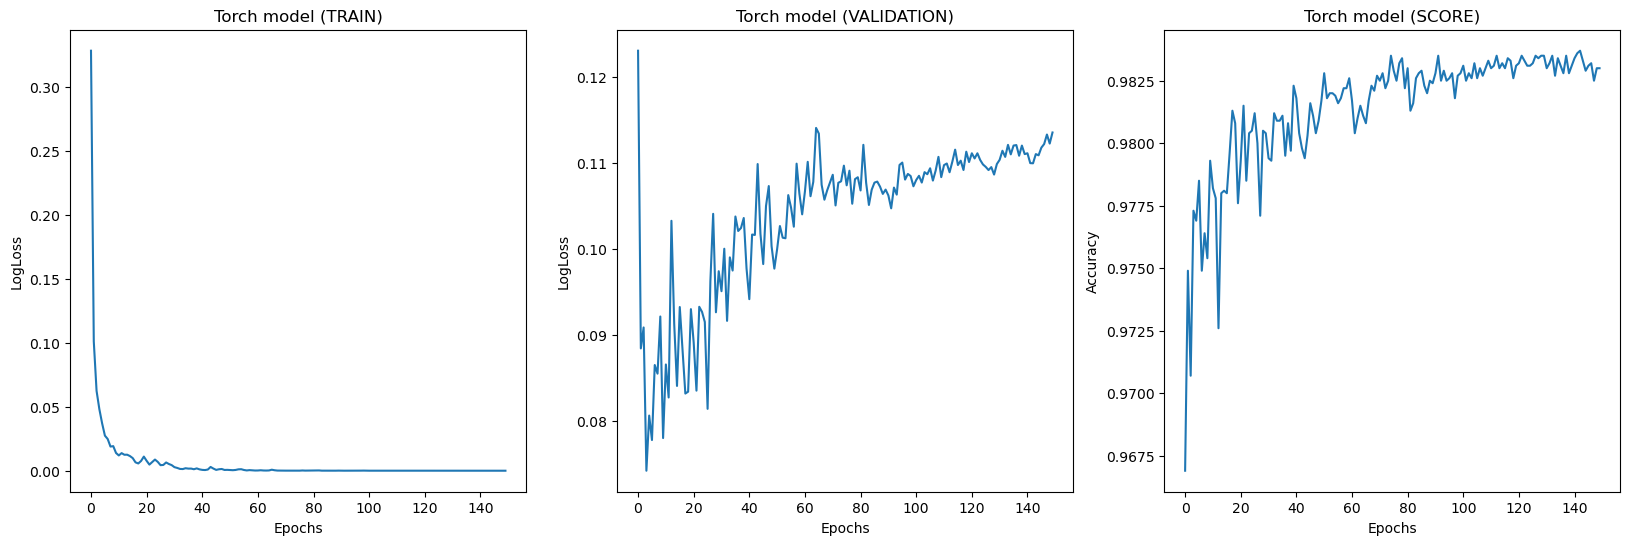

In [505]:
fig, (train, val, score) = plt.subplots(1, 3, figsize=(20, 6))

train.set_xlabel("Epochs")
train.set_ylabel("LogLoss")
train.set_title("Torch model (TRAIN)")

val.set_xlabel("Epochs")
val.set_ylabel("LogLoss")
val.set_title("Torch model (VALIDATION)")

score.set_xlabel("Epochs")
score.set_ylabel("Accuracy")
score.set_title("Torch model (SCORE)")

val.plot(epoch_val_losses)
train.plot(epoch_train_losses)
score.plot(scores);

## Torch score

In [506]:
torch_model.load_state_dict(best_model)
y_test_pred = torch_model(X_test)
test_score  = (y_test == y_test_pred.argmax(axis=1)).sum() / y_test.shape[0]
print(f"Accuracy on test: {round(test_score.data.numpy()*100,2)} %")

Accuracy on test: 98.43 %


Torch score is almost equal